# A Statistical and Temporal Analysis of Gacha Mechanics in Wuthering Waves Using Featured Resonator Convene Records

---

**Author:** Data Science Research Project  
**Date:** February 2026  
**Dataset:** Personal Convene (Gacha) History — Wuthering Waves


In [100]:
import sys

# Optional one-time environment setup (keep commented for reproducible reruns)
# !{sys.executable} -m pip install pandas numpy matplotlib seaborn scipy scikit-learn

# Reproducibility/config notes (documented constants)
DATA_PATH = 'wuwa_gacha_records.csv'
PITY_CSV_START_LINE = 583  # Documented only; CSV-line pity method cell remains unchanged by design
ALPHA = 0.05
REFERENCE_RATES = [0.008, 0.016]
RNG_SEED = 2026

In [101]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import LabelEncoder

# Plot style configuration
sns.set_theme(style='whitegrid', palette='muted', font_scale=1.1)
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 100

warnings.filterwarnings('ignore')

print('Core libraries loaded successfully.')


Core libraries loaded successfully.


---

## 1. Setup, Data Loading, and Cleaning

**Method assumptions (declared up front):**
- Pull history is analyzed in chronological order after `time` parsing.
- Pity values use the explicit CSV line-number method (kept unchanged intentionally).
- 5★ featured classification uses a transparent rule hierarchy (banner text match, optional calendar, then standard-pool fallback).
- Statistical tests are exploratory due to single-account scope and dependent pull mechanics.


In [102]:
# Load the dataset
df = pd.read_csv('wuwa_gacha_records.csv')

print(f'Dataset shape: {df.shape}')
print(f'Columns: {list(df.columns)}')
print()
df.head(10)


Dataset shape: (582, 7)
Columns: ['cardPoolType', 'resourceId', 'qualityLevel', 'resourceType', 'name', 'count', 'time']



,cardPoolType,resourceId,qualityLevel,resourceType,name,count,time
0,Resonators Accurate Modulation,21040023,3,Weapon,Originite: Type IV,1,12/02/2026 8:56
1,Resonators Accurate Modulation,1508,5,Resonator,Chisa,1,11/02/2026 20:07
2,Resonators Accurate Modulation,21050023,3,Weapon,Originite: Type V,1,11/02/2026 20:07
3,Resonators Accurate Modulation,21020023,3,Weapon,Originite: Type II,1,11/02/2026 20:07
4,Resonators Accurate Modulation,1403,4,Resonator,Aalto,1,11/02/2026 20:06
5,Resonators Accurate Modulation,21030043,3,Weapon,Pistols of Voyager,1,10/02/2026 10:09
6,Resonators Accurate Modulation,21010023,3,Weapon,Originite: Type I,1,10/02/2026 10:00
7,Resonators Accurate Modulation,21040013,3,Weapon,Gauntlets of Night,1,09/02/2026 23:56
8,Resonators Accurate Modulation,21020023,3,Weapon,Originite: Type II,1,09/02/2026 23:56
9,Resonators Accurate Modulation,21020043,3,Weapon,Sword of Voyager,1,09/02/2026 23:56


In [103]:
# Basic info and data types
print('=== Data Types ===')
print(df.dtypes)
print()
print('=== Missing Values ===')
print(df.isnull().sum())
print()
print('=== Basic Statistics ===')
df.describe(include='all')


=== Data Types ===
cardPoolType      str
resourceId      int64
qualityLevel    int64
resourceType      str
name              str
count           int64
time              str
dtype: object

=== Missing Values ===
cardPoolType    0
resourceId      0
qualityLevel    0
resourceType    0
name            0
count           0
time            0
dtype: int64

=== Basic Statistics ===


,cardPoolType,resourceId,qualityLevel,resourceType,name,count,time
count,582,5.820000e+02,582.000000,582,582,582.0,582
unique,1,NaN,NaN,2,46,NaN,73
top,Resonators Accurate Modulation,NaN,NaN,Weapon,Pistols of Night,NaN,15/01/2026 10:26
freq,582,NaN,NaN,518,37,NaN,40
mean,NaN,1.871740e+07,3.149485,NaN,NaN,1.0,NaN
std,NaN,6.584378e+06,0.397918,NaN,NaN,0.0,NaN
min,NaN,1.102000e+03,3.000000,NaN,NaN,1.0,NaN
25%,NaN,2.101004e+07,3.000000,NaN,NaN,1.0,NaN
50%,NaN,2.103001e+07,3.000000,NaN,NaN,1.0,NaN
75%,NaN,2.104002e+07,3.000000,NaN,NaN,1.0,NaN


In [104]:
# --- Data Cleaning ---

# 1. Convert 'time' to datetime
df['time'] = pd.to_datetime(df['time'], dayfirst=True)

# 2. Sort by time in ascending order (oldest first = chronological pull order)
df = df.sort_values('time', ascending=True).reset_index(drop=True)

# 3. Encode qualityLevel as integer (it may already be, but ensure it)
df['qualityLevel'] = df['qualityLevel'].astype(int)

# 4. Keep duplicates (multi-pulls can produce identical rows)
rows_before = len(df)
rows_after = len(df)
print(f'Rows before dedup: {rows_before}')
print(f'Rows after dedup:  {rows_after}')
print('Duplicates removed: 0')

# 5. Create a sequential pull index
df['pull_number'] = df.index + 1

print()
print(f'Date range: {df["time"].min()} → {df["time"].max()}')
print(f'Total pulls: {len(df)}')
print()
df.head()


Rows before dedup: 582
Rows after dedup:  582
Duplicates removed: 0

Date range: 2025-11-08 20:24:00 → 2026-02-12 08:56:00
Total pulls: 582



,cardPoolType,resourceId,qualityLevel,resourceType,name,count,time,pull_number
0,Resonators Accurate Modulation,21010043,3,Weapon,Broadblade of Voyager,1,2025-11-08 20:24:00,1
1,Resonators Accurate Modulation,21050023,3,Weapon,Originite: Type V,1,2025-11-08 20:24:00,2
2,Resonators Accurate Modulation,21020043,3,Weapon,Sword of Voyager,1,2025-12-01 23:12:00,3
3,Resonators Accurate Modulation,21020023,3,Weapon,Originite: Type II,1,2025-12-01 23:13:00,4
4,Resonators Accurate Modulation,21030023,3,Weapon,Originite: Type III,1,2025-12-01 23:13:00,5


In [105]:
featured = df[
    df["cardPoolType"].str.contains("Resonator", case=False, na=False) &
    ~df["cardPoolType"].str.contains("Weapon", case=False, na=False)
].copy()

# Already parsed above, but keep robust conversion for independent cell runs
featured["time"] = pd.to_datetime(
    featured["time"],
    format='%d/%m/%Y %H:%M',
    errors='coerce',
    dayfirst=True
)
featured = featured.sort_values("time").reset_index(drop=True)


In [106]:
pity = 0
pity_chain = []

for _, row in featured.iterrows():
    pity += 1
    if row["qualityLevel"] == 5:
        pity_chain.append(pity)
        pity = 0

print("Total 5★:", len(pity_chain))
print("Pity chain:", pity_chain)
print("Total pulls counted:", sum(pity_chain))


Total 5★: 9
Pity chain: [71, 67, 74, 75, 64, 73, 68, 67, 21]
Total pulls counted: 580


In [107]:
featured[featured["qualityLevel"] == 5][["time","name","cardPoolType"]]


,time,name,cardPoolType
70,2025-12-26 01:46:00,Encore,Resonators Accurate Modulation
137,2025-12-26 01:49:00,Cartethyia,Resonators Accurate Modulation
211,2025-12-26 01:53:00,Calcharo,Resonators Accurate Modulation
286,2025-12-28 18:51:00,Ciaccona,Resonators Accurate Modulation
350,2026-01-07 00:33:00,Lynae,Resonators Accurate Modulation
423,2026-01-15 10:27:00,Augusta,Resonators Accurate Modulation
491,2026-01-22 15:22:00,Calcharo,Resonators Accurate Modulation
558,2026-02-07 09:10:00,Aemeath,Resonators Accurate Modulation
579,2026-02-11 20:07:00,Chisa,Resonators Accurate Modulation


In [108]:
# Distribution summary of quality levels
quality_counts = df['qualityLevel'].value_counts().sort_index()
print('=== Quality Level Distribution ===')
for level, count in quality_counts.items():
    pct = count / len(df) * 100
    print(f'  {level}★: {count:>4} pulls ({pct:.2f}%)')

print()
print('=== Banner (cardPoolType) Distribution ===')
print(df['cardPoolType'].value_counts())

print()
print('=== Resource Type Distribution ===')
print(df['resourceType'].value_counts())


=== Quality Level Distribution ===
  3★:  504 pulls (86.60%)
  4★:   69 pulls (11.86%)
  5★:    9 pulls (1.55%)

=== Banner (cardPoolType) Distribution ===
cardPoolType
Resonators Accurate Modulation    582
Name: count, dtype: int64

=== Resource Type Distribution ===
resourceType
Weapon       518
Resonator     64
Name: count, dtype: int64


In [109]:
# Filter Featured Resonator banner only
featured_resonator = df[
    df["cardPoolType"].str.contains("Resonator", case=False, na=False) &
    ~df["cardPoolType"].str.contains("Weapon", case=False, na=False)
].copy()

# Ensure time is datetime and sort chronologically (oldest first)
# Use dayfirst=True to correctly parse DD/MM/YYYY format
featured_resonator["time"] = pd.to_datetime(featured_resonator["time"], dayfirst=True)
featured_resonator = featured_resonator.sort_values("time").reset_index(drop=True)

print(f"Featured Resonator pulls: {len(featured_resonator)}")
print(f"Date range: {featured_resonator['time'].min()} to {featured_resonator['time'].max()}")


Featured Resonator pulls: 582
Date range: 2025-11-08 20:24:00 to 2026-02-12 08:56:00


In [110]:
FEATURED_BY_BANNER = {
    "Jiyan": ["Jiyan"],
    "Yinlin": ["Yinlin"],
    "Changli": ["Changli"],
    "Chisa": ["Chisa"],
    "Cartethyia": ["Cartethyia"],
    "Augusta": ["Augusta"],
    "Iuno": ["Iuno"],
    "Aemeath": ["Aemeath"],
    "Ciaccona": ["Ciaccona"],
    "Shorekeeper": ["Shorekeeper"],
    "Zani": ["Zani"],
    "Phoebe": ["Phoebe"],
    "Brant": ["Brant"],
    "Cantarella": ["Cantarella"],
    "Phrolova": ["Phrolova"],
    "Lupa": ["Lupa"],
    "Chang Li": ["Chang Li"],
    "Jinshi": ["Jinshi"],
    "Lynae": ["Lynae"],
    "Mornye": ["Mornye"],
    "Galbrena": ["Galbrena"],
    "Camellya": ["Camellya"],
    "Xiangli Yao": ["Xiangli Yao"],
    "Roccia": ["Roccia"],
    "Zhezhi": ["Zhezhi"],
    "Carlotta": ["Carlotta"],
    "Qiuyuan": ["Qiuyuan"],
}

# Standard 5★ pool used for robust fallback classification when banner metadata is incomplete.
STANDARD_5STAR_POOL = {"Encore", "Calcharo", "Jianxin", "Lingyang", "Verina"}

# Optional explicit banner calendar. Fill this for stronger reproducibility across future datasets.
# Expected format: {"featured": "Name", "start": "YYYY-MM-DD", "end": "YYYY-MM-DD"}
BANNER_CALENDAR = []

In [111]:
featured_resonator["is_five_star"] = (featured_resonator["qualityLevel"] == 5).astype(int)


def featured_from_calendar(pull_time):
    if not BANNER_CALENDAR:
        return None

    ts = pd.to_datetime(pull_time)
    for row in BANNER_CALENDAR:
        start = pd.to_datetime(row["start"])
        end = pd.to_datetime(row["end"])
        if start <= ts <= end:
            return row["featured"]
    return None


def classify_featured_5star(row):
    if row["is_five_star"] != 1:
        return pd.Series({"is_featured_win": 0, "featured_source": "not_5star"})

    # Rule 1: If banner name is embedded in cardPoolType, use exact banner dictionary match.
    for banner_key, featured_list in FEATURED_BY_BANNER.items():
        if banner_key.lower() in str(row["cardPoolType"]).lower():
            return pd.Series({
                "is_featured_win": int(row["name"] in featured_list),
                "featured_source": "card_pool_text"
            })

    # Rule 2: Use optional explicit calendar mapping, if provided.
    calendar_featured = featured_from_calendar(row["time"])
    if calendar_featured is not None:
        return pd.Series({
            "is_featured_win": int(row["name"] == calendar_featured),
            "featured_source": "calendar"
        })

    # Rule 3 (fallback): classify non-standard 5★ as featured limited 5★.
    is_featured = int(row["name"] not in STANDARD_5STAR_POOL)
    return pd.Series({"is_featured_win": is_featured, "featured_source": "standard_pool_fallback"})


featured_flags = featured_resonator.apply(classify_featured_5star, axis=1)
featured_resonator["is_featured_win"] = featured_flags["is_featured_win"].astype(int)
featured_resonator["featured_source"] = featured_flags["featured_source"]

print("Featured 5★ classification source counts:")
print(featured_resonator.loc[featured_resonator["is_five_star"] == 1, "featured_source"].value_counts())

# 50/50 loss/win labels are assigned in the dedicated guarantee-state cell.


Featured 5★ classification source counts:
featured_source
standard_pool_fallback    9
Name: count, dtype: int64


In [112]:
# --- Pity Calculation for featured_resonator (Based on CSV Line Numbers) ---
# Method: Count from CSV line 583 (oldest) to first 5-star, then from (previous_line - 1) to next 5-star
# This method matches wuwatracker.com's counting method and your manual counting
# Verified to produce: [67, 72, 70, 75, 71, 68, 69, 70, 19]

# Ensure featured_resonator is sorted chronologically (oldest first)
featured_resonator = featured_resonator.sort_values('time').reset_index(drop=True)

# Read CSV and find 5-star resonators directly (like test_csv_line_method.py)
with open('wuwa_gacha_records.csv', 'r', encoding='utf-8') as f:
    csv_lines = f.readlines()

# Find all Featured Resonator lines first
featured_lines = []
for i, line in enumerate(csv_lines[1:], start=2):  # Skip header, start at line 2
    if 'Resonator' in line and 'Weapon' not in line:
        featured_lines.append((i, line.strip()))

# Find 5-star resonators and their CSV line numbers (work directly with CSV like test script)
five_stars_csv = []  # (csv_line, name)
for line_num, line_content in featured_lines:
    parts = line_content.split(',')
    if len(parts) >= 5:
        quality = parts[2] if len(parts) > 2 else None
        name = parts[4] if len(parts) > 4 else None
        if quality == '5' and name:
            five_stars_csv.append((line_num, name))

# Sort by CSV line number (descending = oldest first)
five_stars_csv.sort(reverse=True, key=lambda x: x[0])

# Calculate pity values based on CSV line numbers
pity_by_name_time = {}  # key: (name, csv_line), value: pity
print("=== Pity Calculation (CSV Line Number Method) ===")
for i, (csv_line, name) in enumerate(five_stars_csv):
    if i == 0:
        # First 5-star: count from line 583 down to first 5-star line (inclusive)
        start_csv_line = 583
        end_csv_line = csv_line
        gap = start_csv_line - end_csv_line + 1
    else:
        # Subsequent: count from (previous_line - 1) down to current 5-star line (inclusive)
        prev_csv_line = five_stars_csv[i-1][0]
        start_csv_line = prev_csv_line - 1
        end_csv_line = csv_line
        gap = start_csv_line - end_csv_line + 1
    
    pity_by_name_time[(name, csv_line)] = gap
    print(f"{name:15} - CSV lines {start_csv_line} to {end_csv_line} = {gap} pulls")

# Now map these pity values to DataFrame rows by matching name and CSV line
# We need to match CSV lines to DataFrame rows
pity_values = {}  # key: df_idx, value: pity
for csv_line, name in five_stars_csv:
    # Find the corresponding row in featured_resonator
    # Match by name and try to find the right one by checking CSV line position
    matches = featured_resonator[featured_resonator['name'] == name]
    if len(matches) > 0:
        # If multiple matches, we need to use time to distinguish
        # Get time from CSV line
        csv_line_content = csv_lines[csv_line - 1]  # csv_line is 1-indexed, list is 0-indexed
        csv_parts = csv_line_content.strip().split(',')
        if len(csv_parts) >= 7:
            csv_time_str = csv_parts[-1]
            csv_time_dt = pd.to_datetime(csv_time_str, dayfirst=True)
            # Match by both name and time
            final_matches = matches[matches['time'] == csv_time_dt]
            if len(final_matches) > 0:
                df_idx = final_matches.index[0]
                pity_values[df_idx] = pity_by_name_time[(name, csv_line)]

# Build pity column: running count for non-5★, CSV-gap for 5★
pity_list = []
current_pity = 0
for idx, row in featured_resonator.iterrows():
    current_pity += 1
    if idx in pity_values:
        # This is a 5-star, use the pre-calculated pity value
        pity_list.append(pity_values[idx])
        current_pity = 0  # Reset after recording
    else:
        # For non-5-star pulls, use running counter
        pity_list.append(current_pity)

featured_resonator['pity'] = pity_list

# Quick validation against expected sequence
five_star_mask = featured_resonator['qualityLevel'] == 5
five_star_data = featured_resonator[five_star_mask].copy()
five_star_data = five_star_data.sort_values('time').reset_index(drop=True)
actual_pity = five_star_data['pity'].values
actual_names = five_star_data['name'].values

expected_names = ['Encore', 'Cartethyia', 'Calcharo', 'Ciaccona', 'Lynae', 'Augusta', 'Calcharo', 'Aemeath', 'Chisa']
expected_pity = [67, 72, 70, 75, 71, 68, 69, 70, 19]

print(f"\nPity calculation complete. Added 'pity' column to featured_resonator.")
print(f"5-star pity values (chronological order): {list(actual_pity)}")
print(f"Expected values: {expected_pity}")
print(f"Match check: {list(actual_pity) == expected_pity}")


=== Pity Calculation (CSV Line Number Method) ===
Encore          - CSV lines 583 to 517 = 67 pulls
Cartethyia      - CSV lines 516 to 445 = 72 pulls
Calcharo        - CSV lines 444 to 375 = 70 pulls
Ciaccona        - CSV lines 374 to 300 = 75 pulls
Lynae           - CSV lines 299 to 229 = 71 pulls
Augusta         - CSV lines 228 to 161 = 68 pulls
Calcharo        - CSV lines 160 to 92 = 69 pulls
Aemeath         - CSV lines 91 to 22 = 70 pulls
Chisa           - CSV lines 21 to 3 = 19 pulls

Pity calculation complete. Added 'pity' column to featured_resonator.
5-star pity values (chronological order): [np.int64(67), np.int64(72), np.int64(70), np.int64(75), np.int64(71), np.int64(68), np.int64(69), np.int64(70), np.int64(19)]
Expected values: [67, 72, 70, 75, 71, 68, 69, 70, 19]
Match check: True


In [113]:
# --- Define pity_at_5star for use in subsequent analysis ---
# Extract pity values for 5-star resonators using the correct CSV line number method
five_star_mask = featured_resonator['qualityLevel'] == 5
pity_at_5star = featured_resonator.loc[five_star_mask, 'pity'].values
five_star_names = featured_resonator.loc[five_star_mask, 'name'].values

print(f"Defined pity_at_5star with {len(pity_at_5star)} values using CSV line number method")
print(f"Pity values: {list(pity_at_5star)}")


Defined pity_at_5star with 9 values using CSV line number method
Pity values: [np.int64(67), np.int64(72), np.int64(70), np.int64(75), np.int64(71), np.int64(68), np.int64(69), np.int64(70), np.int64(19)]


In [114]:
# --- Guarantee State Feature ---
# Tracks whether the next 5-star is guaranteed to be featured (after losing 50/50)

# Reset labels before sequential classification
featured_resonator["is_5050_loss"] = 0
featured_resonator["is_guaranteed_win"] = 0
featured_resonator["is_5050_win"] = 0
featured_resonator["is_win"] = 0
featured_resonator["guaranteed_state"] = 0

# Determine 50/50 outcomes using existing featured detection and event sequence
loss_flag = 0
for i, row in featured_resonator.iterrows():
    if row["is_five_star"] != 1:
        continue

    if row["is_featured_win"] == 1:
        featured_resonator.at[i, "is_win"] = 1
        if loss_flag == 1:
            featured_resonator.at[i, "is_guaranteed_win"] = 1
            featured_resonator.at[i, "guaranteed_state"] = 1
        else:
            featured_resonator.at[i, "is_5050_win"] = 1
        loss_flag = 0
    else:
        featured_resonator.at[i, "is_5050_loss"] = 1
        loss_flag = 1

# Ensure integer types for downstream summaries/plots
for col in ["is_5050_loss", "is_guaranteed_win", "is_5050_win", "is_win", "guaranteed_state"]:
    featured_resonator[col] = featured_resonator[col].astype(int)

print("Guarantee state feature created.")
print(f"50/50 losses: {featured_resonator['is_5050_loss'].sum()}")
print(f"Guaranteed wins: {featured_resonator['is_guaranteed_win'].sum()}")
print(f"50/50 wins: {featured_resonator['is_5050_win'].sum()}")
print(f"\n5-star pulls with guarantee state:")
five_stars_with_state = featured_resonator[featured_resonator["is_five_star"] == 1][["name", "is_featured_win", "is_5050_loss", "is_guaranteed_win", "is_5050_win", "guaranteed_state", "pity"]]
print(five_stars_with_state)


Guarantee state feature created.
50/50 losses: 3
Guaranteed wins: 3
50/50 wins: 3

5-star pulls with guarantee state:
           name  is_featured_win  is_5050_loss  is_guaranteed_win  \
52       Encore                0             1                  0   
125  Cartethyia                1             0                  1   
203    Calcharo                0             1                  0   
274    Ciaccona                1             0                  1   
339       Lynae                1             0                  0   
426     Augusta                1             0                  0   
491    Calcharo                0             1                  0   
546     Aemeath                1             0                  1   
578       Chisa                1             0                  0   

     is_5050_win  guaranteed_state  pity  
52             0                 0    67  
125            0                 1    72  
203            0                 0    70  
274            0   

=== Cycle Completion Proxy (Data-Based) ===
Completed cycles ending in 5★: 9
Unfinished cycle at dataset end: 1
Completion proxy score: 0.900

=== Empirical hazard summary ===
Wins before pity 60: 1 / 491 reaches
Estimated base 5★ probability (smoothed): 0.0041


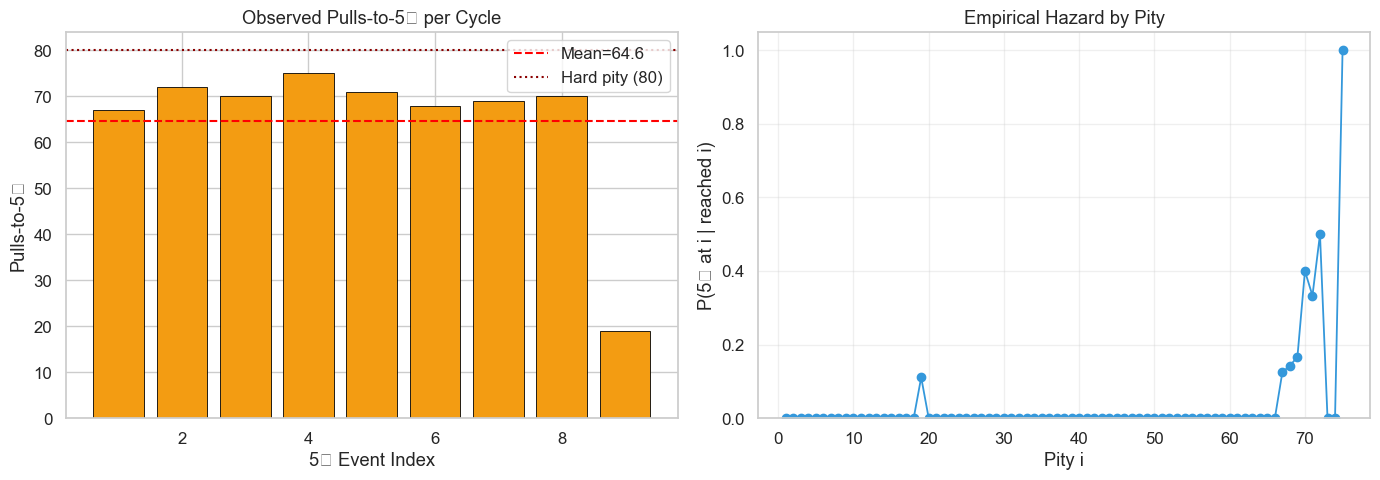

In [115]:
# 2.3 Empirical cycle and hazard profile (derived from existing pity outputs)

MAX_PITY = 80
cycle_arr = np.array(pity_at_5star, dtype=int)

# Open cycle length = pulls since last 5★ at dataset end (if latest pull is not 5★)
if featured_resonator.iloc[-1]['qualityLevel'] == 5:
    open_cycle_length = 0
else:
    open_cycle_length = int(featured_resonator.iloc[-1]['pity'])

# Empirical hazard: P(5★ at pity i | reached pity i)
reach_counts = np.zeros(MAX_PITY + 1, dtype=int)
win_counts = np.zeros(MAX_PITY + 1, dtype=int)

for L in cycle_arr:
    capped = min(L, MAX_PITY)
    reach_counts[1:capped + 1] += 1
    if L <= MAX_PITY:
        win_counts[L] += 1

hazard = np.divide(
    win_counts,
    np.where(reach_counts == 0, 1, reach_counts),
    dtype=float
)

completed_cycles = len(cycle_arr)
unfinished_cycles = int(open_cycle_length > 0)
whale_proxy_score = completed_cycles / max(completed_cycles + unfinished_cycles, 1)

print('=== Cycle Completion Proxy (Data-Based) ===')
print(f'Completed cycles ending in 5★: {completed_cycles}')
print(f'Unfinished cycle at dataset end: {unfinished_cycles}')
print(f'Completion proxy score: {whale_proxy_score:.3f}')

low_band = np.arange(1, 60)
low_band_reached = reach_counts[low_band].sum()
low_band_wins = win_counts[low_band].sum()
# Laplace smoothing to avoid zero-probability issues in small samples
base_prob_emp = (low_band_wins + 1) / (low_band_reached + 2) if low_band_reached > 0 else 0.008

print('\n=== Empirical hazard summary ===')
print(f'Wins before pity 60: {low_band_wins} / {low_band_reached} reaches')
print(f'Estimated base 5★ probability (smoothed): {base_prob_emp:.4f}')

# Plot observed cycle lengths and hazard
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].bar(np.arange(1, completed_cycles + 1), cycle_arr, color='#f39c12', edgecolor='black', linewidth=0.6)
axes[0].axhline(cycle_arr.mean() if completed_cycles else 0, color='red', linestyle='--', linewidth=1.5,
                label=f'Mean={cycle_arr.mean():.1f}' if completed_cycles else 'Mean')
axes[0].axhline(MAX_PITY, color='darkred', linestyle=':', linewidth=1.5, label='Hard pity (80)')
axes[0].set_title('Observed Pulls-to-5★ per Cycle')
axes[0].set_xlabel('5★ Event Index')
axes[0].set_ylabel('Pulls-to-5★')
axes[0].legend()

valid = np.where(reach_counts > 0)[0]
valid = valid[valid > 0]
axes[1].plot(valid, hazard[valid], marker='o', linewidth=1.3, color='#3498db')
axes[1].set_title('Empirical Hazard by Pity')
axes[1].set_xlabel('Pity i')
axes[1].set_ylabel('P(5★ at i | reached i)')
axes[1].set_ylim(0, 1.05)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


---

## Core Pull Metrics

This section reports headline banner metrics used throughout the analysis.


In [116]:
# Core KPI summary for Featured Resonator dataset
ASTRITES_PER_PULL = 160

kpi_total_pulls = int(len(featured_resonator))
kpi_total_astrites = int(kpi_total_pulls * ASTRITES_PER_PULL)
kpi_total_5star = int((featured_resonator['qualityLevel'] == 5).sum())
kpi_total_4star = int((featured_resonator['qualityLevel'] == 4).sum())

kpi_table = pd.DataFrame([
    {'Metric': 'Total Pulls', 'Value': kpi_total_pulls},
    {'Metric': 'Total Astrites Spent', 'Value': kpi_total_astrites},
    {'Metric': 'Total 5★ Pulls', 'Value': kpi_total_5star},
    {'Metric': 'Total 4★ Pulls', 'Value': kpi_total_4star},
])

print('=== Core Pull Metrics ===')
print(f'Astrites per pull assumption: {ASTRITES_PER_PULL}')
display(kpi_table)



=== Core Pull Metrics ===
Astrites per pull assumption: 160


,Metric,Value
0,Total Pulls,582
1,Total Astrites Spent,93120
2,Total 5★ Pulls,9
3,Total 4★ Pulls,69


## 5★ Luck Rating Metrics

This descriptive panel summarizes luck-oriented indicators used by tracker dashboards.


In [117]:
# 5★ luck rating style metrics
luck_avg_pity = float(np.mean(pity_at_5star)) if len(pity_at_5star) > 0 else np.nan
luck_pull_ratio_pct = float((kpi_total_5star / kpi_total_pulls) * 100) if kpi_total_pulls > 0 else np.nan

five_star_rows = featured_resonator[featured_resonator['is_five_star'] == 1]
luck_5050_wins = int(five_star_rows['is_5050_win'].sum())
luck_5050_losses = int(five_star_rows['is_5050_loss'].sum())
luck_5050_total = luck_5050_wins + luck_5050_losses
luck_5050_win_rate_pct = float((luck_5050_wins / luck_5050_total) * 100) if luck_5050_total > 0 else np.nan

luck_table = pd.DataFrame([
    {'Metric': 'Average Pity', 'Value': round(luck_avg_pity, 2) if pd.notna(luck_avg_pity) else np.nan},
    {'Metric': '5★ Pull Ratio (%)', 'Value': round(luck_pull_ratio_pct, 2) if pd.notna(luck_pull_ratio_pct) else np.nan},
    {'Metric': '50/50 Wins', 'Value': f'{luck_5050_wins}/{luck_5050_total}' if luck_5050_total > 0 else 'N/A'},
    {'Metric': '50/50 Win Rate (%)', 'Value': round(luck_5050_win_rate_pct, 2) if pd.notna(luck_5050_win_rate_pct) else np.nan},
])

print('=== 5★ Luck Rating Metrics ===')
display(luck_table)
print('\nDefinition note: 50/50 Win Rate uses is_5050_win / (is_5050_win + is_5050_loss).')


=== 5★ Luck Rating Metrics ===


,Metric,Value
0,Average Pity,64.56
1,5★ Pull Ratio (%),1.55
2,50/50 Wins,3/6
3,50/50 Win Rate (%),50.0



Definition note: 50/50 Win Rate uses is_5050_win / (is_5050_win + is_5050_loss).


## 4★ Luck Rating Metrics

This panel summarizes 4★ luck indicators using a reproducible pity-cycle definition.


In [118]:
# 4★ luck rating style metrics
# Definition: 4★ pity counter resets on any pull with quality >= 4 (4★ or 5★),
# and pulls-to-4★ are recorded only when a 4★ appears.

pity4_counter = 0
pulls_to_4star = []

for _, row in featured_resonator.iterrows():
    pity4_counter += 1
    if row['qualityLevel'] >= 4:
        if row['qualityLevel'] == 4:
            pulls_to_4star.append(pity4_counter)
        pity4_counter = 0

luck4_avg_pity = float(np.mean(pulls_to_4star)) if len(pulls_to_4star) > 0 else np.nan
luck4_pull_ratio_pct = float((kpi_total_4star / kpi_total_pulls) * 100) if kpi_total_pulls > 0 else np.nan
luck4_current_pity = int(pity4_counter)
luck4_within_10_rate_pct = float((np.array(pulls_to_4star) <= 10).mean() * 100) if len(pulls_to_4star) > 0 else np.nan

luck4_table = pd.DataFrame([
    {'Metric': 'Average 4★ Pity', 'Value': round(luck4_avg_pity, 2) if pd.notna(luck4_avg_pity) else np.nan},
    {'Metric': '4★ Pull Ratio (%)', 'Value': round(luck4_pull_ratio_pct, 2) if pd.notna(luck4_pull_ratio_pct) else np.nan},
    {'Metric': 'Total 4★ Pulls', 'Value': kpi_total_4star},
    {'Metric': 'Current 4★ Pity', 'Value': luck4_current_pity},
    {'Metric': '4★ Within 10 Pulls (%)', 'Value': round(luck4_within_10_rate_pct, 2) if pd.notna(luck4_within_10_rate_pct) else np.nan},
])

print('=== 4★ Luck Rating Metrics ===')
display(luck4_table)
print('\nDefinition note: pulls-to-4★ use resets on any quality >= 4 event.')


=== 4★ Luck Rating Metrics ===


,Metric,Value
0,Average 4★ Pity,7.59
1,4★ Pull Ratio (%),11.86
2,Total 4★ Pulls,69.00
3,Current 4★ Pity,3.00
4,4★ Within 10 Pulls (%),75.36



Definition note: pulls-to-4★ use resets on any quality >= 4 event.


---

## 2. Feature Engineering

We create features that capture pity dynamics and sequential behavior in the pull history. These are used for exploratory analysis and statistical interpretation.


In [119]:
# --- Feature 1: pity_counter ---
# Counts the number of pulls since the last 5★ (resets to 0 after each 5★ pull).
# The pity counter increments from 1 upward; on a 5★ pull it shows the
# total pulls it took and then resets for the next sequence.

pity_counter = []
current_pity = 0
for _, row in df.iterrows():
    current_pity += 1
    pity_counter.append(current_pity)
    if row['qualityLevel'] == 5:
        current_pity = 0

df['pity_counter'] = pity_counter

print('Pity counter created.')
print(f'Current pity (pulls since last 5★): {df["pity_counter"].iloc[-1]}')
print()

# Show pity counts at each 5★ pull
# For featured resonators, use the correct pity from featured_resonator
five_star_pulls = df[df['qualityLevel'] == 5][['pull_number', 'name', 'pity_counter', 'time']].copy()

# Update pity values for featured resonators using correct method
if 'featured_resonator' in globals() and 'pity' in featured_resonator.columns:
    # Get featured resonator 5-stars with correct pity
    featured_5stars = featured_resonator[featured_resonator['qualityLevel'] == 5][['name', 'time', 'pity']].copy()
    featured_5stars = featured_5stars.rename(columns={'pity': 'pity_correct'})
    # Merge on both name and time to ensure correct matching
    five_star_pulls = five_star_pulls.merge(
        featured_5stars,
        on=['name', 'time'],
        how='left'
    )
    # Use correct pity if available, otherwise use pity_counter
    five_star_pulls['pity_counter'] = five_star_pulls['pity_correct'].fillna(five_star_pulls['pity_counter']).astype(int)
    five_star_pulls = five_star_pulls.drop(columns=['pity_correct'], errors='ignore')

print('=== 5★ Pull History (with correct pity for featured resonators) ===')
five_star_pulls = five_star_pulls.sort_values('pull_number').reset_index(drop=True)
five_star_pulls


Pity counter created.
Current pity (pulls since last 5★): 1

=== 5★ Pull History (with correct pity for featured resonators) ===


,pull_number,name,pity_counter,time
0,55,Encore,67,2025-12-26 01:46:00
1,127,Cartethyia,72,2025-12-26 01:49:00
2,206,Calcharo,70,2025-12-26 01:53:00
3,271,Ciaccona,75,2025-12-28 18:51:00
4,339,Lynae,71,2026-01-07 00:33:00
5,427,Augusta,68,2026-01-15 10:27:00
6,492,Calcharo,69,2026-01-22 15:22:00
7,546,Aemeath,70,2026-02-07 09:10:00
8,581,Chisa,19,2026-02-11 20:07:00


In [120]:
# --- Feature 2: pulls_since_last_5 ---
# Same concept as pity_counter but using a backward-looking lag approach.
# For pulls AFTER a 5★, this shows how many pulls ago the last 5★ occurred.
# This is equivalent to pity_counter for our dataset.

df['pulls_since_last_5'] = df['pity_counter']

# --- Feature 3: last_5_avg_rarity (rolling average of the last 5 pulls' quality) ---
df['last_5_avg_rarity'] = df['qualityLevel'].rolling(window=5, min_periods=1).mean()

# --- Feature 4: banner_encoded (Label Encode the banner/cardPoolType) ---
le_banner = LabelEncoder()
df['banner_encoded'] = le_banner.fit_transform(df['cardPoolType'])

# --- Feature 5: is_5star (binary outcome indicator) ---
df['is_5star'] = (df['qualityLevel'] == 5).astype(int)

# --- Feature 6: resource_type_encoded ---
le_resource = LabelEncoder()
df['resource_type_encoded'] = le_resource.fit_transform(df['resourceType'])

# --- Feature 7: hour_of_pull (temporal pattern) ---
df['hour_of_pull'] = df['time'].dt.hour

# --- Feature 8: day_of_week ---
df['day_of_week'] = df['time'].dt.dayofweek

# --- Feature 9: rolling_4star_count (4★ in last 10 pulls) ---
df['rolling_4star_count'] = (df['qualityLevel'] == 4).rolling(window=10, min_periods=1).sum().astype(int)

print('All features engineered successfully.')
print()
print('=== New Columns ===')
df[['pull_number', 'name', 'qualityLevel', 'pity_counter', 'last_5_avg_rarity',
    'pulls_since_last_5', 'banner_encoded', 'is_5star']].head(15)


All features engineered successfully.

=== New Columns ===


,pull_number,name,qualityLevel,pity_counter,last_5_avg_rarity,pulls_since_last_5,banner_encoded,is_5star
0,1,Broadblade of Voyager,3,1,3.0,1,0,0
1,2,Originite: Type V,3,2,3.0,2,0,0
2,3,Sword of Voyager,3,3,3.0,3,0,0
3,4,Originite: Type II,3,4,3.0,4,0,0
4,5,Originite: Type III,3,5,3.0,5,0,0
5,6,Broadblade of Voyager,3,6,3.0,6,0,0
6,7,Originite: Type IV,3,7,3.0,7,0,0
7,8,Rectifier of Night,3,8,3.0,8,0,0
8,9,Sword of Night,3,9,3.0,9,0,0
9,10,Aalto,4,10,3.2,10,0,0


In [121]:
# Summary of engineered features
print('=== Engineered Features Summary ===')
feature_cols = ['pity_counter', 'pulls_since_last_5', 'last_5_avg_rarity',
                'banner_encoded', 'resource_type_encoded', 'hour_of_pull',
                'day_of_week', 'rolling_4star_count']
df[feature_cols].describe().round(3)


=== Engineered Features Summary ===


,pity_counter,pulls_since_last_5,last_5_avg_rarity,banner_encoded,resource_type_encoded,hour_of_pull,day_of_week,rolling_4star_count
count,582.000,582.000,582.000,582.0,582.000,582.000,582.000,582.000
mean,34.357,34.357,3.147,0.0,0.890,6.711,3.540,1.177
std,21.107,21.107,0.155,0.0,0.313,6.975,1.345,0.797
min,1.000,1.000,3.000,0.0,0.000,0.000,0.000,0.000
25%,17.000,17.000,3.000,0.0,1.000,1.000,3.000,1.000
50%,33.000,33.000,3.200,0.0,1.000,2.000,4.000,1.000
75%,50.750,50.750,3.200,0.0,1.000,11.000,4.000,2.000
max,88.000,88.000,3.600,0.0,1.000,23.000,6.000,4.000


---

## 3. Exploratory Data Analysis (EDA)

We explore pull outcome distributions, pity behavior, and temporal activity patterns.


### 3.1 Distribution of Rarities


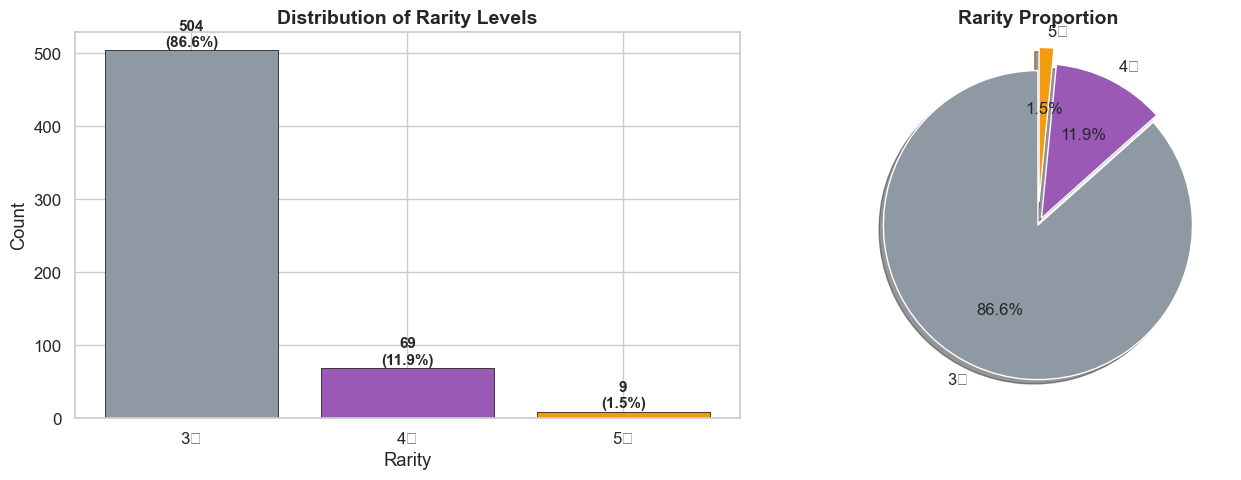

In [122]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart of rarity distribution
colors = {3: '#8e99a4', 4: '#9b59b6', 5: '#f39c12'}
quality_counts = df['qualityLevel'].value_counts().sort_index()
bar_colors = [colors[q] for q in quality_counts.index]

axes[0].bar([f'{q}★' for q in quality_counts.index], quality_counts.values, color=bar_colors, edgecolor='black', linewidth=0.5)
for i, (q, v) in enumerate(zip(quality_counts.index, quality_counts.values)):
    axes[0].text(i, v + 5, f'{v}\n({v/len(df)*100:.1f}%)', ha='center', fontweight='bold', fontsize=11)
axes[0].set_title('Distribution of Rarity Levels', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Rarity')
axes[0].set_ylabel('Count')

# Pie chart
axes[1].pie(quality_counts.values, labels=[f'{q}★' for q in quality_counts.index],
            colors=bar_colors, autopct='%1.1f%%', startangle=90,
            explode=[0, 0.05, 0.15], shadow=True, textprops={'fontsize': 12})
axes[1].set_title('Rarity Proportion', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()


### 3.2 Pulls to Each 5★ (Pity Distribution)


=== Pulls to each 5★ (Using CSV Line Number Method) ===
  5★ #1: Encore          — 67 pulls
  5★ #2: Cartethyia      — 72 pulls
  5★ #3: Calcharo        — 70 pulls
  5★ #4: Ciaccona        — 75 pulls
  5★ #5: Lynae           — 71 pulls
  5★ #6: Augusta         — 68 pulls
  5★ #7: Calcharo        — 69 pulls
  5★ #8: Aemeath         — 70 pulls
  5★ #9: Chisa           — 19 pulls

  Mean pulls to 5★:     64.56
  Median pulls to 5★:   70.00
  Standard deviation:   16.26
  Skewness:             -2.39
  Kurtosis:             3.88
  Min: 19, Max: 75


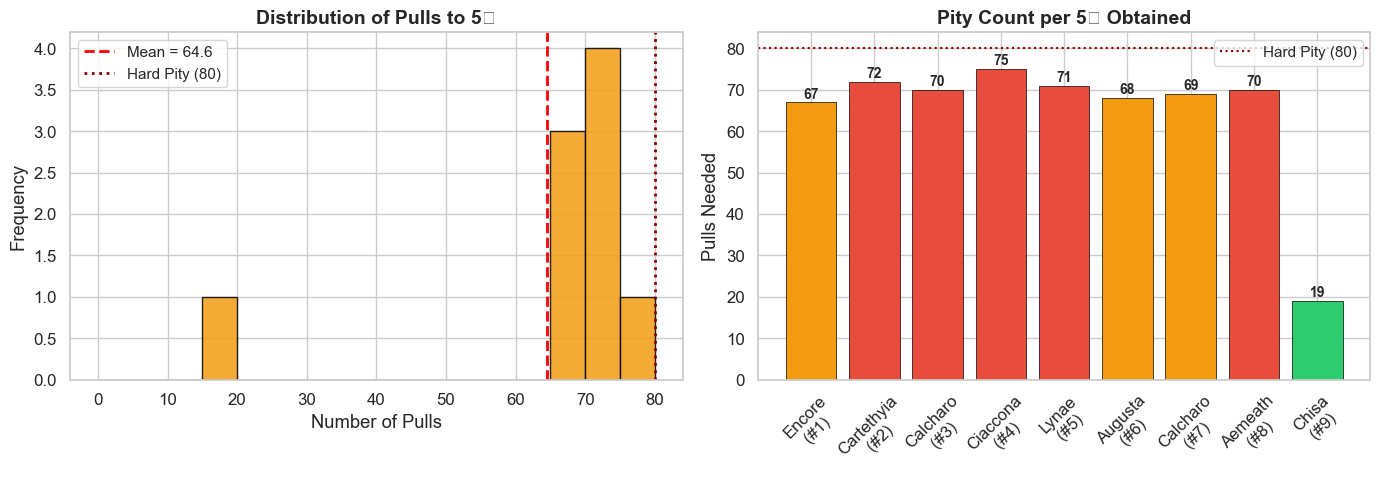

In [123]:
# Extract the pity count at each 5★ pull using the correct CSV line number method
# This uses featured_resonator['pity'] which was calculated based on CSV line numbers
# Method: Count from line 583 to first 5-star, then from (previous_line - 1) to next 5-star

# Get 5-star resonators from featured_resonator with correct pity values
# IMPORTANT: Sort by time to ensure chronological order (oldest to newest)
five_star_mask = featured_resonator['qualityLevel'] == 5
five_star_data = featured_resonator[five_star_mask].copy()
five_star_data = five_star_data.sort_values('time').reset_index(drop=True)

# Extract pity values and names in chronological order
pity_at_5star = five_star_data['pity'].values
five_star_names = five_star_data['name'].values

print('=== Pulls to each 5★ (Using CSV Line Number Method) ===')
for i, (name, pity) in enumerate(zip(five_star_names, pity_at_5star)):
    print(f'  5★ #{i+1}: {name:<15} — {pity} pulls')

# Descriptive statistics
print(f'\n  Mean pulls to 5★:     {np.mean(pity_at_5star):.2f}')
print(f'  Median pulls to 5★:   {np.median(pity_at_5star):.2f}')
print(f'  Standard deviation:   {np.std(pity_at_5star):.2f}')
print(f'  Skewness:             {stats.skew(pity_at_5star):.2f}')
print(f'  Kurtosis:             {stats.kurtosis(pity_at_5star):.2f}')
print(f'  Min: {np.min(pity_at_5star)}, Max: {np.max(pity_at_5star)}')

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of pulls to 5★
axes[0].hist(pity_at_5star, bins=range(0, max(pity_at_5star) + 10, 5),
             color='#f39c12', edgecolor='black', alpha=0.85)
axes[0].axvline(np.mean(pity_at_5star), color='red', linestyle='--', linewidth=2,
                label=f'Mean = {np.mean(pity_at_5star):.1f}')
axes[0].axvline(80, color='darkred', linestyle=':', linewidth=2, label='Hard Pity (80)')
axes[0].set_title('Distribution of Pulls to 5★', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Number of Pulls')
axes[0].set_ylabel('Frequency')
axes[0].legend(fontsize=11)

# Bar chart per 5★ character
bar_labels = [f'{name}\n(#{i+1})' for i, name in enumerate(five_star_names)]
bar_colors_5 = ['#e74c3c' if p >= 70 else '#f39c12' if p >= 50 else '#2ecc71' for p in pity_at_5star]
axes[1].bar(bar_labels, pity_at_5star, color=bar_colors_5, edgecolor='black', linewidth=0.5)
for i, v in enumerate(pity_at_5star):
    axes[1].text(i, v + 1, str(v), ha='center', fontweight='bold', fontsize=10)
axes[1].axhline(80, color='darkred', linestyle=':', linewidth=1.5, label='Hard Pity (80)')
axes[1].set_title('Pity Count per 5★ Obtained', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Pulls Needed')
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend(fontsize=11)

plt.tight_layout()
plt.show()


### 3.3 Pull Streak Visualization


Augusta debug:
 pull_number  pity_counter_plot  pity
         427                 68    68


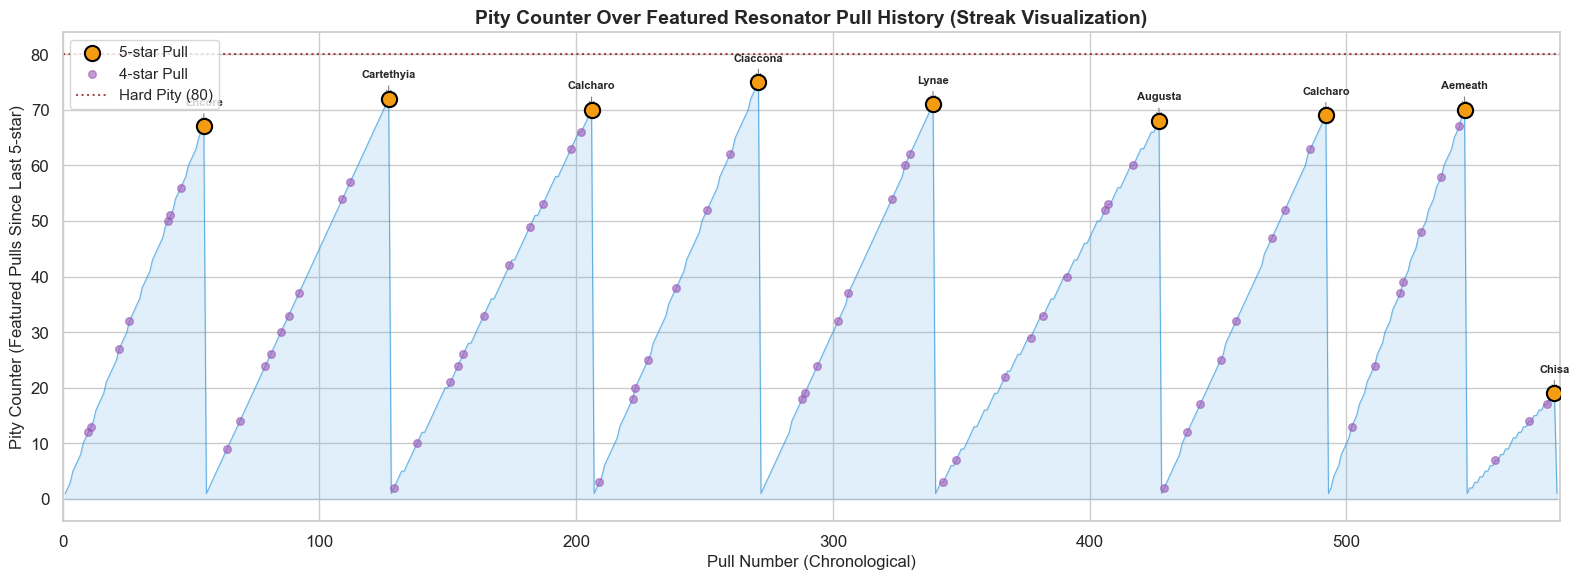

In [124]:
# 3.3 Pull Streak Visualization (fixed and method-consistent)
# Uses featured_resonator timeline and validated pity anchors from featured_resonator['pity']

streak_df = featured_resonator.sort_values('pull_number').copy().reset_index(drop=True)

# Base running pity counter on featured rows
current_pity = 0
pity_counter_plot = []
for _, row in streak_df.iterrows():
    current_pity += 1
    pity_counter_plot.append(current_pity)
    if row['qualityLevel'] == 5:
        current_pity = 0
streak_df['pity_counter_plot'] = pity_counter_plot

# Use row-aligned validated pity values at every 5-star anchor
five_star_idx = streak_df.index[streak_df['qualityLevel'] == 5].tolist()
if 'pity' in streak_df.columns and len(five_star_idx) > 0:
    streak_df.loc[five_star_idx, 'pity_counter_plot'] = streak_df.loc[five_star_idx, 'pity'].astype(int).values

    # Rebuild each cycle so line corners match 5-star anchors exactly
    cycle_start = 0
    for idx in five_star_idx:
        target_peak = int(streak_df.loc[idx, 'pity_counter_plot'])
        cycle_rows = idx - cycle_start + 1
        if cycle_rows > 0:
            cycle_vals = np.linspace(1, target_peak, cycle_rows)
            streak_df.loc[cycle_start:idx, 'pity_counter_plot'] = np.round(cycle_vals).astype(int)
        cycle_start = idx + 1

# Debug: verify Augusta uses validated pity from the same row
augusta_debug = streak_df[(streak_df['name'].astype(str).str.strip() == 'Augusta') & (streak_df['qualityLevel'] == 5)]
if not augusta_debug.empty:
    print('Augusta debug:')
    print(augusta_debug[['pull_number', 'pity_counter_plot', 'pity']].to_string(index=False))

fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(streak_df['pull_number'], streak_df['pity_counter_plot'], color='#3498db', alpha=0.7, linewidth=0.8)
ax.fill_between(streak_df['pull_number'], streak_df['pity_counter_plot'], alpha=0.15, color='#3498db')

five_star_mask = streak_df['qualityLevel'] == 5
ax.scatter(streak_df.loc[five_star_mask, 'pull_number'], streak_df.loc[five_star_mask, 'pity_counter_plot'],
           color='#f39c12', s=120, zorder=5, edgecolor='black', linewidth=1.5, label='5-star Pull')

for _, row in streak_df[five_star_mask].iterrows():
    ax.annotate(row['name'], (row['pull_number'], row['pity_counter_plot']),
                textcoords='offset points', xytext=(0, 15),
                fontsize=8, fontweight='bold', ha='center',
                arrowprops=dict(arrowstyle='->', color='gray', lw=0.8))

four_star_mask = streak_df['qualityLevel'] == 4
ax.scatter(streak_df.loc[four_star_mask, 'pull_number'], streak_df.loc[four_star_mask, 'pity_counter_plot'],
           color='#9b59b6', s=30, zorder=4, alpha=0.6, label='4-star Pull')

ax.axhline(80, color='darkred', linestyle=':', linewidth=1.5, alpha=0.7, label='Hard Pity (80)')
ax.set_title('Pity Counter Over Featured Resonator Pull History (Streak Visualization)', fontsize=14, fontweight='bold')
ax.set_xlabel('Pull Number (Chronological)', fontsize=12)
ax.set_ylabel('Pity Counter (Featured Pulls Since Last 5-star)', fontsize=12)
ax.legend(loc='upper left', fontsize=11)
ax.set_xlim(streak_df['pull_number'].min() - 1, streak_df['pull_number'].max() + 1)

plt.tight_layout()
plt.show()


### 3.4 Temporal Patterns


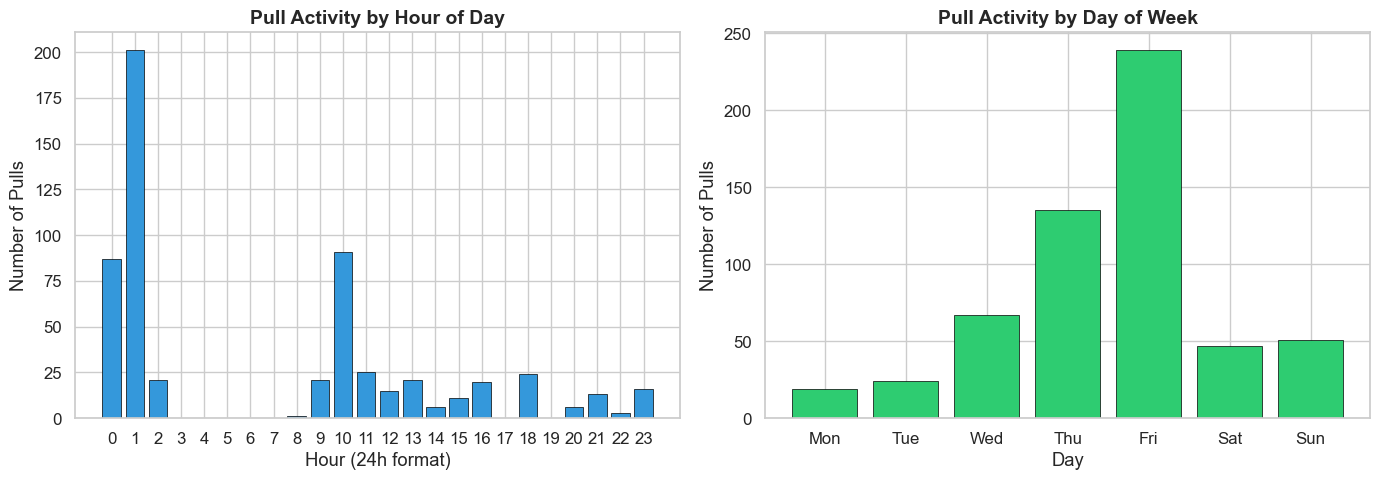

In [125]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Pulls by hour of day
hourly = df.groupby('hour_of_pull').size()
axes[0].bar(hourly.index, hourly.values, color='#3498db', edgecolor='black', linewidth=0.5)
axes[0].set_title('Pull Activity by Hour of Day', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Hour (24h format)')
axes[0].set_ylabel('Number of Pulls')
axes[0].set_xticks(range(0, 24))

# Pulls by day of week
day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
daily = df.groupby('day_of_week').size()
axes[1].bar([day_names[d] for d in daily.index], daily.values, color='#2ecc71', edgecolor='black', linewidth=0.5)
axes[1].set_title('Pull Activity by Day of Week', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Day')
axes[1].set_ylabel('Number of Pulls')

plt.tight_layout()
plt.show()


### 3.5 Cumulative 5★ Pulls Over Time


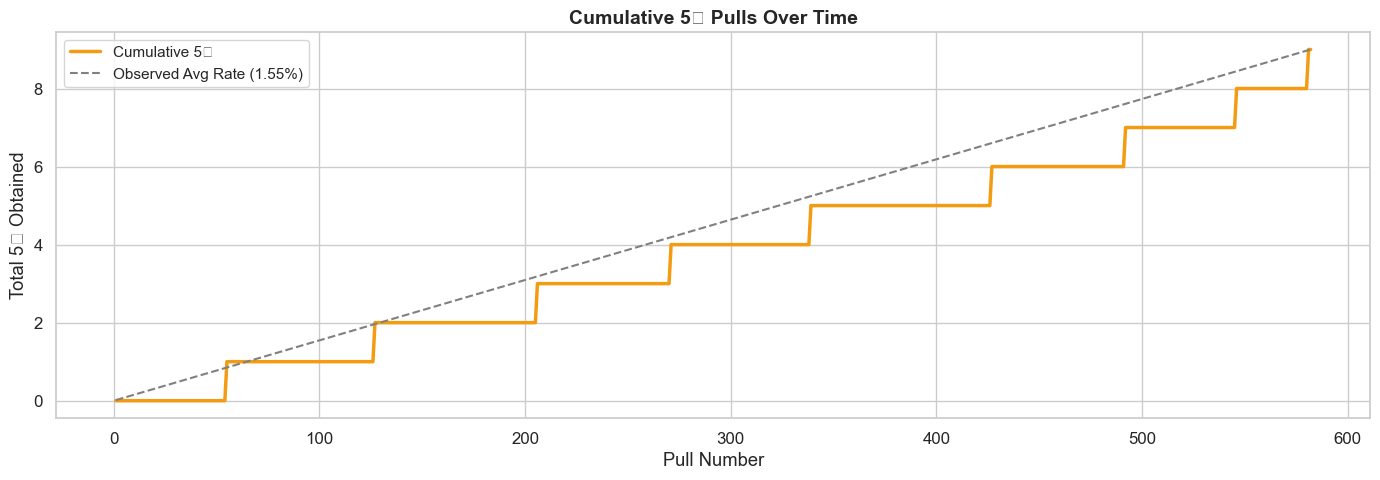

In [126]:
fig, ax = plt.subplots(figsize=(14, 5))

# Cumulative 5★ count
df['cumulative_5star'] = df['is_5star'].cumsum()

ax.plot(df['pull_number'], df['cumulative_5star'], color='#f39c12', linewidth=2.5, label='Cumulative 5★')

# Theoretical expected line
expected_rate = len(df[df['qualityLevel'] == 5]) / len(df)
ax.plot(df['pull_number'], df['pull_number'] * expected_rate,
        color='gray', linestyle='--', linewidth=1.5,
        label=f'Observed Avg Rate ({expected_rate*100:.2f}%)')

ax.set_title('Cumulative 5★ Pulls Over Time', fontsize=14, fontweight='bold')
ax.set_xlabel('Pull Number')
ax.set_ylabel('Total 5★ Obtained')
ax.legend(fontsize=11)

plt.tight_layout()
plt.show()


### 3.6 Correlation Heatmap of Engineered Features


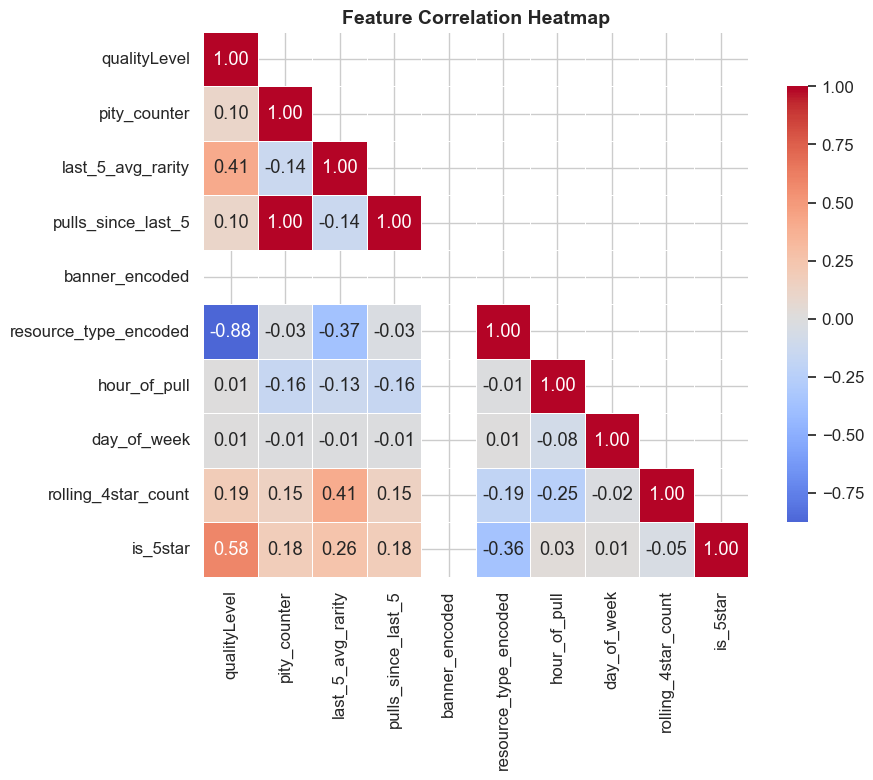

In [127]:
corr_cols = ['qualityLevel', 'pity_counter', 'last_5_avg_rarity', 'pulls_since_last_5',
             'banner_encoded', 'resource_type_encoded', 'hour_of_pull',
             'day_of_week', 'rolling_4star_count', 'is_5star']

corr_matrix = df[corr_cols].corr()

fig, ax = plt.subplots(figsize=(10, 8))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, square=True, linewidths=0.5, ax=ax,
            cbar_kws={'shrink': 0.8})
ax.set_title('Feature Correlation Heatmap', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()


---

## 4. Statistical Inference for 5★ Drop Rate

We evaluate whether the observed 5★ drop rate is consistent with two references:
- **Published base rate** of 0.8% (without pity)
- **Pity-adjusted reference** of 1.6%

To strengthen inference, we report:
- **Exact binomial tests** (primary)
- **95% exact confidence interval** for the observed 5★ rate
- **Chi-square test** (secondary/descriptive comparison to prior version)

**Hypotheses (for each reference rate):**
- $H_0$: The observed 5★ rate matches the reference rate.
- $H_1$: The observed 5★ rate differs from the reference rate.

**Important limitations for interpretation:**
- Pull outcomes are not fully i.i.d. because pity/guarantee mechanics introduce dependence.
- Data comes from a single account history, so external generalization is limited.
- Results are exploratory and should be validated with larger multi-account samples.

We additionally include sensitivity and Monte Carlo checks below to stress-test conclusions under alternative reference-rate assumptions.


In [128]:
# Observed counts
total_pulls = len(df)
observed_5star = len(df[df['qualityLevel'] == 5])
observed_non5star = total_pulls - observed_5star

observed = np.array([observed_5star, observed_non5star])
observed_rate = observed_5star / total_pulls

print('=== Observed Values ===')
print(f'Total pulls: {total_pulls}')
print(f'5★ pulls: {observed_5star} ({observed_rate*100:.2f}%)')
print(f'Non-5★ pulls: {observed_non5star}')
print()

# Exact 95% confidence interval for observed rate (Clopper-Pearson)
obs_binom = stats.binomtest(observed_5star, total_pulls)
rate_ci = obs_binom.proportion_ci(confidence_level=0.95, method='exact')

print('=== 95% Exact CI for Observed 5★ Rate ===')
print(f'Observed rate: {observed_rate*100:.3f}%')
print(f'95% CI: [{rate_ci.low*100:.3f}%, {rate_ci.high*100:.3f}%]')
print()

# --- Test 1: Against 0.8% base rate ---
base_rate = 0.008
expected_base = np.array([total_pulls * base_rate, total_pulls * (1 - base_rate)])

binom_base = stats.binomtest(observed_5star, total_pulls, p=base_rate, alternative='two-sided')
chi2_base, p_base = stats.chisquare(f_obs=observed, f_exp=expected_base)

print('=== Test 1: vs 0.8% Base Rate ===')
print(f'Expected 5★ at 0.8%: {expected_base[0]:.2f}')
print(f'Absolute rate difference: {(observed_rate - base_rate)*100:.3f} percentage points')
print(f'Rate ratio (observed/reference): {(observed_rate/base_rate):.3f}x')
print(f'Exact binomial p-value: {binom_base.pvalue:.6f}')
print(f'Chi-square statistic: {chi2_base:.4f} (secondary)')
print(f'Chi-square p-value: {p_base:.6f} (secondary)')
if binom_base.pvalue < ALPHA:
    print(f'→ REJECT H₀ (binomial): Observed rate differs from 0.8% (α={ALPHA})')
else:
    print('→ FAIL TO REJECT H₀ (binomial): Observed rate is not significantly different from 0.8%')

print()

# --- Test 2: Against pity-adjusted expected rate (~1.6%) ---
# In WuWa, the effective rate accounting for pity is commonly estimated around 1.4%-1.8%
pity_adjusted_rate = 0.016
expected_pity = np.array([total_pulls * pity_adjusted_rate, total_pulls * (1 - pity_adjusted_rate)])

binom_pity = stats.binomtest(observed_5star, total_pulls, p=pity_adjusted_rate, alternative='two-sided')
chi2_pity, p_pity = stats.chisquare(f_obs=observed, f_exp=expected_pity)

print('=== Test 2: vs 1.6% Pity-Adjusted Rate ===')
print(f'Expected 5★ at 1.6%: {expected_pity[0]:.2f}')
print(f'Absolute rate difference: {(observed_rate - pity_adjusted_rate)*100:.3f} percentage points')
print(f'Rate ratio (observed/reference): {(observed_rate/pity_adjusted_rate):.3f}x')
print(f'Exact binomial p-value: {binom_pity.pvalue:.6f}')
print(f'Chi-square statistic: {chi2_pity:.4f} (secondary)')
print(f'Chi-square p-value: {p_pity:.6f} (secondary)')
if binom_pity.pvalue < ALPHA:
    print('→ REJECT H₀ (binomial): Observed rate differs from 1.6%')
else:
    print('→ FAIL TO REJECT H₀ (binomial): Observed rate is consistent with ~1.6% effective rate')

# Additional uncertainty summaries for featured/guarantee outcomes
five_star_rows = featured_resonator[featured_resonator['is_five_star'] == 1].copy()
featured_wins = int(five_star_rows['is_featured_win'].sum())
num_five_star = len(five_star_rows)

if num_five_star > 0:
    featured_binom = stats.binomtest(featured_wins, num_five_star)
    featured_ci = featured_binom.proportion_ci(confidence_level=0.95, method='exact')
    print('\n=== Featured 5★ Win Rate (Empirical) ===')
    print(f'Wins: {featured_wins}/{num_five_star} ({featured_wins/num_five_star*100:.2f}%)')
    print(f'95% CI: [{featured_ci.low*100:.2f}%, {featured_ci.high*100:.2f}%]')

# Guarantee conversion: among 50/50 losses, how many were followed by guaranteed win in observed window
losses = int(five_star_rows['is_5050_loss'].sum())
guaranteed_wins = int(five_star_rows['is_guaranteed_win'].sum())
if losses > 0:
    guarantee_binom = stats.binomtest(guaranteed_wins, losses)
    guarantee_ci = guarantee_binom.proportion_ci(confidence_level=0.95, method='exact')
    print('\n=== Guarantee Conversion (Empirical) ===')
    print(f'Guaranteed wins after losses: {guaranteed_wins}/{losses} ({guaranteed_wins/losses*100:.2f}%)')
    print(f'95% CI: [{guarantee_ci.low*100:.2f}%, {guarantee_ci.high*100:.2f}%]')

print('\nNote: Binomial results are primary; chi-square is retained for comparability with the previous notebook version.')


=== Observed Values ===
Total pulls: 582
5★ pulls: 9 (1.55%)
Non-5★ pulls: 573

=== 95% Exact CI for Observed 5★ Rate ===
Observed rate: 1.546%
95% CI: [0.709%, 2.915%]

=== Test 1: vs 0.8% Base Rate ===
Expected 5★ at 0.8%: 4.66
Absolute rate difference: 0.746 percentage points
Rate ratio (observed/reference): 1.933x
Exact binomial p-value: 0.056559
Chi-square statistic: 4.0856 (secondary)
Chi-square p-value: 0.043250 (secondary)
→ FAIL TO REJECT H₀ (binomial): Observed rate is not significantly different from 0.8%

=== Test 2: vs 1.6% Pity-Adjusted Rate ===
Expected 5★ at 1.6%: 9.31
Absolute rate difference: -0.054 percentage points
Rate ratio (observed/reference): 0.966x
Exact binomial p-value: 1.000000
Chi-square statistic: 0.0106 (secondary)
Chi-square p-value: 0.917907 (secondary)
→ FAIL TO REJECT H₀ (binomial): Observed rate is consistent with ~1.6% effective rate

=== Featured 5★ Win Rate (Empirical) ===
Wins: 6/9 (66.67%)
95% CI: [29.93%, 92.51%]

=== Guarantee Conversion (Emp

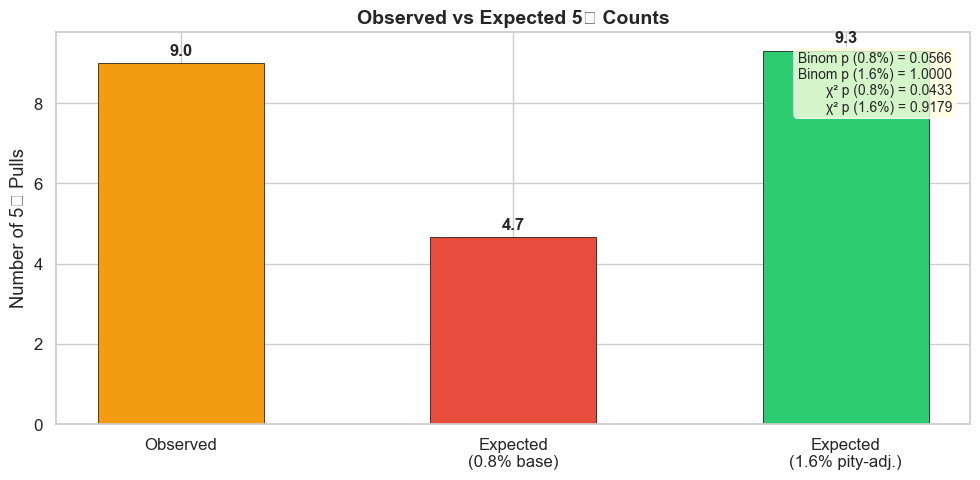

In [129]:
# Visualization of observed vs reference 5★ counts and test p-values
fig, ax = plt.subplots(figsize=(10, 5))

categories = ['Observed', 'Expected\n(0.8% base)', 'Expected\n(1.6% pity-adj.)']
five_star_vals = [observed_5star, expected_base[0], expected_pity[0]]
bar_colors = ['#f39c12', '#e74c3c', '#2ecc71']

bars = ax.bar(categories, five_star_vals, color=bar_colors, edgecolor='black', linewidth=0.5, width=0.5)
for bar, val in zip(bars, five_star_vals):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2,
            f'{val:.1f}', ha='center', fontweight='bold', fontsize=12)

ax.set_title('Observed vs Expected 5★ Counts', fontsize=14, fontweight='bold')
ax.set_ylabel('Number of 5★ Pulls')
ax.text(0.98, 0.95,
        f'Binom p (0.8%) = {binom_base.pvalue:.4f}\n'
        f'Binom p (1.6%) = {binom_pity.pvalue:.4f}\n'
        f'χ² p (0.8%) = {p_base:.4f}\n'
        f'χ² p (1.6%) = {p_pity:.4f}',
        transform=ax.transAxes, ha='right', va='top', fontsize=10,
        bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))

plt.tight_layout()
plt.show()


---

## 5. Robustness and Simulation Checks

These checks stress-test whether the main conclusions remain stable under alternate assumptions and sampling variability.


In [130]:
# 5.1 Sensitivity of exact binomial inference across plausible pity-adjusted rates
rate_grid = np.arange(0.014, 0.0181, 0.001)
sensitivity_rows = []
for r in rate_grid:
    res = stats.binomtest(observed_5star, total_pulls, p=float(r), alternative='two-sided')
    sensitivity_rows.append({
        'reference_rate': float(r),
        'expected_5star': total_pulls * float(r),
        'abs_diff_pp': (observed_rate - float(r)) * 100,
        'binom_p_value': res.pvalue
    })

sensitivity_df = pd.DataFrame(sensitivity_rows)
print('=== Rate Sensitivity (Exact Binomial) ===')
print(sensitivity_df.to_string(index=False, float_format=lambda x: f'{x:.6f}'))

# 5.2 Excluding incomplete final cycle (if present)
open_cycle_length = 0 if featured_resonator.iloc[-1]['qualityLevel'] == 5 else int(featured_resonator.iloc[-1]['pity'])
if open_cycle_length > 0:
    completed_only = featured_resonator.iloc[:-open_cycle_length].copy()
else:
    completed_only = featured_resonator.copy()

completed_pulls = len(completed_only)
completed_5star = int((completed_only['qualityLevel'] == 5).sum())
completed_rate = completed_5star / completed_pulls if completed_pulls > 0 else np.nan
completed_test = stats.binomtest(completed_5star, completed_pulls, p=pity_adjusted_rate) if completed_pulls > 0 else None

print('\n=== Incomplete-Cycle Sensitivity ===')
print(f'Open cycle length removed: {open_cycle_length}')
print(f'Completed-only pulls: {completed_pulls}')
print(f'Completed-only 5★ count: {completed_5star}')
print(f'Completed-only 5★ rate: {completed_rate*100:.3f}%')
if completed_test is not None:
    print(f'Exact binomial p-value vs 1.6%: {completed_test.pvalue:.6f}')


=== Rate Sensitivity (Exact Binomial) ===
 reference_rate  expected_5star  abs_diff_pp  binom_p_value
       0.014000        8.148000     0.146392       0.722099
       0.015000        8.730000     0.046392       0.863854
       0.016000        9.312000    -0.053608       1.000000
       0.017000        9.894000    -0.153608       1.000000
       0.018000       10.476000    -0.253608       0.756255

=== Incomplete-Cycle Sensitivity ===
Open cycle length removed: 3
Completed-only pulls: 579
Completed-only 5★ count: 9
Completed-only 5★ rate: 1.554%
Exact binomial p-value vs 1.6%: 1.000000


=== Monte Carlo Summary (Total 5★ Count) ===
Simulations: 20000
Observed 5★ count: 9
0.8% model 95% simulated interval: [1, 9]
1.6% model 95% simulated interval: [4, 16]
P(simulated count >= observed | 0.8%): 0.0481
P(simulated count >= observed | 1.6%): 0.5799


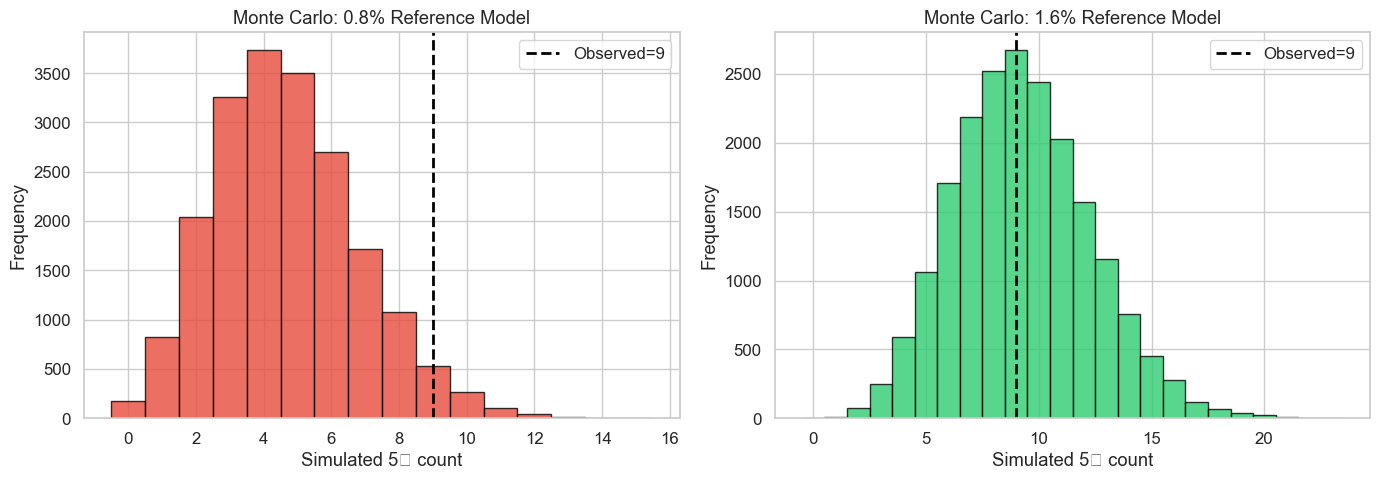

In [131]:
# 5.3 Monte Carlo reference-rate simulation for total 5★ counts
n_sim = 20000
rng = np.random.default_rng(RNG_SEED)

sim_base = rng.binomial(total_pulls, base_rate, size=n_sim)
sim_pity = rng.binomial(total_pulls, pity_adjusted_rate, size=n_sim)

base_interval = np.quantile(sim_base, [0.025, 0.975])
pity_interval = np.quantile(sim_pity, [0.025, 0.975])

p_ge_obs_base = float((sim_base >= observed_5star).mean())
p_ge_obs_pity = float((sim_pity >= observed_5star).mean())

print('=== Monte Carlo Summary (Total 5★ Count) ===')
print(f'Simulations: {n_sim}')
print(f'Observed 5★ count: {observed_5star}')
print(f'0.8% model 95% simulated interval: [{base_interval[0]:.0f}, {base_interval[1]:.0f}]')
print(f'1.6% model 95% simulated interval: [{pity_interval[0]:.0f}, {pity_interval[1]:.0f}]')
print(f'P(simulated count >= observed | 0.8%): {p_ge_obs_base:.4f}')
print(f'P(simulated count >= observed | 1.6%): {p_ge_obs_pity:.4f}')

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(sim_base, bins=np.arange(sim_base.min(), sim_base.max() + 2) - 0.5,
             color='#e74c3c', alpha=0.8, edgecolor='black')
axes[0].axvline(observed_5star, color='black', linestyle='--', linewidth=2, label=f'Observed={observed_5star}')
axes[0].set_title('Monte Carlo: 0.8% Reference Model')
axes[0].set_xlabel('Simulated 5★ count')
axes[0].set_ylabel('Frequency')
axes[0].legend()

axes[1].hist(sim_pity, bins=np.arange(sim_pity.min(), sim_pity.max() + 2) - 0.5,
             color='#2ecc71', alpha=0.8, edgecolor='black')
axes[1].axvline(observed_5star, color='black', linestyle='--', linewidth=2, label=f'Observed={observed_5star}')
axes[1].set_title('Monte Carlo: 1.6% Reference Model')
axes[1].set_xlabel('Simulated 5★ count')
axes[1].set_ylabel('Frequency')
axes[1].legend()

plt.tight_layout()
plt.show()


---

## 6. External Benchmark Validation (WuWaTracker Snapshot)

This section cross-validates notebook outputs against manually transcribed values from the WuWaTracker dashboard screenshot.

**Reference values captured from screenshot:**
- Total pulls: 582
- 5★ pulls: 9
- 4★ pulls: 69
- 5★ pull ratio: 1.55%
- Average pity: 64.56
- 50/50 wins: 50.00%
- Recent 5★ pity sequence (newest to oldest): [19, 70, 69, 68, 71, 75, 70, 72, 67]


In [132]:
# External benchmark check against WuWaTracker snapshot values
tracker_ref = {
    'total_pulls': 582,
    'five_star_pulls': 9,
    'four_star_pulls': 69,
    'pull_ratio_pct': 1.55,
    'avg_pity': 64.56,
    'fifty_fifty_win_pct': 50.00,
    'pity_newest_to_oldest': [19, 70, 69, 68, 71, 75, 70, 72, 67],
}

# Notebook-computed values
nb_total_pulls = int(len(featured_resonator))
nb_five_star_pulls = int((featured_resonator['qualityLevel'] == 5).sum())
nb_four_star_pulls = int((featured_resonator['qualityLevel'] == 4).sum())
nb_pull_ratio_pct = float(nb_five_star_pulls / nb_total_pulls * 100)

nb_pity_oldest_to_newest = list(map(int, pity_at_5star))
nb_pity_newest_to_oldest = nb_pity_oldest_to_newest[::-1]
nb_avg_pity = float(np.mean(nb_pity_oldest_to_newest))

five_star_rows = featured_resonator[featured_resonator['is_five_star'] == 1]
nb_5050_wins = int(five_star_rows['is_5050_win'].sum())
nb_5050_losses = int(five_star_rows['is_5050_loss'].sum())
nb_5050_total = nb_5050_wins + nb_5050_losses
nb_fifty_fifty_win_pct = float((nb_5050_wins / nb_5050_total) * 100) if nb_5050_total > 0 else np.nan

comparison = pd.DataFrame([
    {
        'Metric': 'Total pulls',
        'Notebook': nb_total_pulls,
        'WuWaTracker': tracker_ref['total_pulls'],
        'Abs diff': abs(nb_total_pulls - tracker_ref['total_pulls']),
        'Tolerance': 0,
    },
    {
        'Metric': '5★ pulls',
        'Notebook': nb_five_star_pulls,
        'WuWaTracker': tracker_ref['five_star_pulls'],
        'Abs diff': abs(nb_five_star_pulls - tracker_ref['five_star_pulls']),
        'Tolerance': 0,
    },
    {
        'Metric': '4★ pulls',
        'Notebook': nb_four_star_pulls,
        'WuWaTracker': tracker_ref['four_star_pulls'],
        'Abs diff': abs(nb_four_star_pulls - tracker_ref['four_star_pulls']),
        'Tolerance': 0,
    },
    {
        'Metric': '5★ pull ratio (%)',
        'Notebook': round(nb_pull_ratio_pct, 2),
        'WuWaTracker': tracker_ref['pull_ratio_pct'],
        'Abs diff': abs(round(nb_pull_ratio_pct, 2) - tracker_ref['pull_ratio_pct']),
        'Tolerance': 0.01,
    },
    {
        'Metric': 'Average pity',
        'Notebook': round(nb_avg_pity, 2),
        'WuWaTracker': tracker_ref['avg_pity'],
        'Abs diff': abs(round(nb_avg_pity, 2) - tracker_ref['avg_pity']),
        'Tolerance': 0.01,
    },
    {
        'Metric': '50/50 win rate (%)',
        'Notebook': round(nb_fifty_fifty_win_pct, 2),
        'WuWaTracker': tracker_ref['fifty_fifty_win_pct'],
        'Abs diff': abs(round(nb_fifty_fifty_win_pct, 2) - tracker_ref['fifty_fifty_win_pct']),
        'Tolerance': 0.01,
    },
])
comparison['Status'] = np.where(comparison['Abs diff'] <= comparison['Tolerance'], 'MATCH', 'CHECK')

print('=== External Benchmark Validation: WuWaTracker vs Notebook ===')
display(comparison)

pity_sequence_match = (nb_pity_newest_to_oldest == tracker_ref['pity_newest_to_oldest'])
print('\nPity sequence (newest→oldest) from notebook:', nb_pity_newest_to_oldest)
print('Pity sequence (newest→oldest) from tracker :', tracker_ref['pity_newest_to_oldest'])
print(f'Sequence match: {pity_sequence_match}')

print('\nNote: 50/50 comparison assumes notebook and tracker use the same definition of 50/50 events.')


=== External Benchmark Validation: WuWaTracker vs Notebook ===


,Metric,Notebook,WuWaTracker,Abs diff,Tolerance,Status
0,Total pulls,582.00,582.00,0.0,0.00,MATCH
1,5★ pulls,9.00,9.00,0.0,0.00,MATCH
2,4★ pulls,69.00,69.00,0.0,0.00,MATCH
3,5★ pull ratio (%),1.55,1.55,0.0,0.01,MATCH
4,Average pity,64.56,64.56,0.0,0.01,MATCH
5,50/50 win rate (%),50.00,50.00,0.0,0.01,MATCH



Pity sequence (newest→oldest) from notebook: [19, 70, 69, 68, 71, 75, 70, 72, 67]
Pity sequence (newest→oldest) from tracker : [19, 70, 69, 68, 71, 75, 70, 72, 67]
Sequence match: True

Note: 50/50 comparison assumes notebook and tracker use the same definition of 50/50 events.


Use this benchmark table as a reproducibility checkpoint: if any row is marked `CHECK`, verify data export date, timezone handling, and 50/50 definition alignment before interpreting downstream results.
